In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

import gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from spellchecker import SpellChecker

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

In [2]:
df_tweet_fr_train = pd.read_pickle('../data/final/NotIot_FR_tweets_train.p')
df_tweet_fr_test = pd.read_pickle('../data/final/NotIot_FR_tweets_test.p')
df_tweet_fr_train.columns = ['text', 'emotion']
df_tweet_fr_test.columns = ['text', 'emotion']
df_tweet_fr_test.head()

,text,emotion
0,La technologie clé contre le changement climatique http://t.co/6jwCQsD8Vk,VALORISATION
1,@JMoncomble Probablement une histoire de développement durable/recyclage universitaire toussa. Il est mauvaise ambiance le @MikaelAgopiantz,DEVALORISATION
2,C\'est moi où l\'énergie naturelle est plus forte que d\'habitude...??! :o. Il y a des renversements de situations... http://t.co/0CQyWJvjh3,VALORISATION
3,Nous cherchons à changer l’économie mondiale en nous basant sur le développement durable https://t.co/vjJxQ6ca2S #crowdfunding #économie,VALORISATION
4,@RemiMathis Les achats par l\'Internet sont écologiques: pas d\'embouteillages ni essence ni parking ni RERB puant. On choisit au calme.,VALORISATION


In [3]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    def space_uderscore(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        #return re.sub(r':([a-z&]+)_([a-z&]+):', r'\1\2', input_text)
        return input_text.replace('_',' ')
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(self.space_uderscore).apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [4]:
textcount = TextCounts()
#get text features from train dataset
df_eda_train = textcount.fit_transform(df_tweet_fr_train.text)
df_eda_train['sentiment'] = df_tweet_fr_train.emotion
df_eda_train['origin_text'] = df_tweet_fr_train.text

In [5]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std   min    25%   50%    75%   max
sentiment                                                                     
ACCORD             153.0   18.274510  4.390833  6.0   15.00  19.0  21.00  28.0
AMOUR              8.0     15.125000  6.895910  5.0   9.50   16.0  20.50  24.0
APAISEMENT         9.0     16.333333  4.301163  11.0  14.00  15.0  18.00  26.0
COLERE             209.0   18.363636  4.664908  5.0   15.00  19.0  22.00  30.0
DEPLAISIR          47.0    20.255319  4.007971  8.0   19.00  21.0  23.00  27.0
DERANGEMENT        12.0    17.250000  3.957157  11.0  15.50  17.5  19.50  24.0
DESACCORD          216.0   17.722222  3.654455  8.0   15.00  18.0  21.00  26.0
DEVALORISATION     396.0   18.696970  4.326438  7.0   16.00  19.0  22.00  30.0
ENNUI              4.0     15.750000  3.593976  11.0  14.00  16.5  18.25  19.0
INSATISFACTION     9.0     17.333333  4.213075  14.0  15.00  15

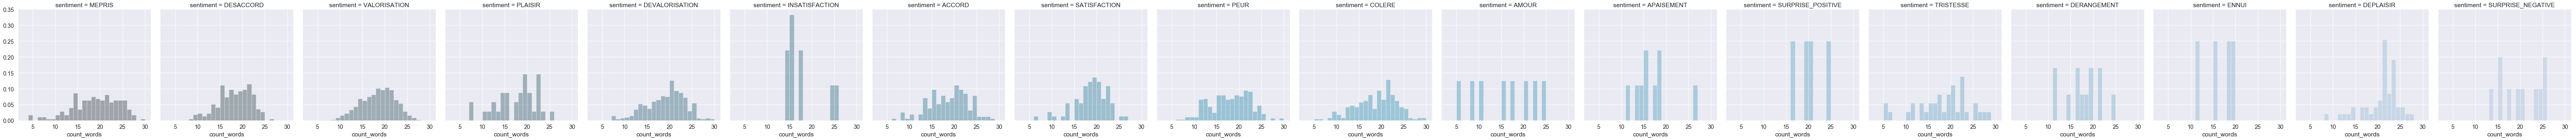

In [6]:
show_dist(df_eda_train, 'count_words')

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min   25%  50%   75%  max
sentiment                                                               
ACCORD             153.0   0.392157  0.671166  0.0  0.00  0.0  1.00  3.0
AMOUR              8.0     0.875000  0.834523  0.0  0.00  1.0  1.25  2.0
APAISEMENT         9.0     0.333333  0.500000  0.0  0.00  0.0  1.00  1.0
COLERE             209.0   0.435407  0.711776  0.0  0.00  0.0  1.00  4.0
DEPLAISIR          47.0    0.489362  0.718463  0.0  0.00  0.0  1.00  2.0
DERANGEMENT        12.0    1.083333  1.505042  0.0  0.00  1.0  1.00  5.0
DESACCORD          216.0   0.495370  0.835256  0.0  0.00  0.0  1.00  4.0
DEVALORISATION     396.0   0.565657  0.822612  0.0  0.00  0.0  1.00  5.0
ENNUI              4.0     0.750000  0.957427  0.0  0.00  0.5  1.25  2.0
INSATISFACTION     9.0     0.222222  0.440959  0.0  0.00  0.0  0.00  1.0
MEPRIS             173.0   0.670520  0.971153  0.0

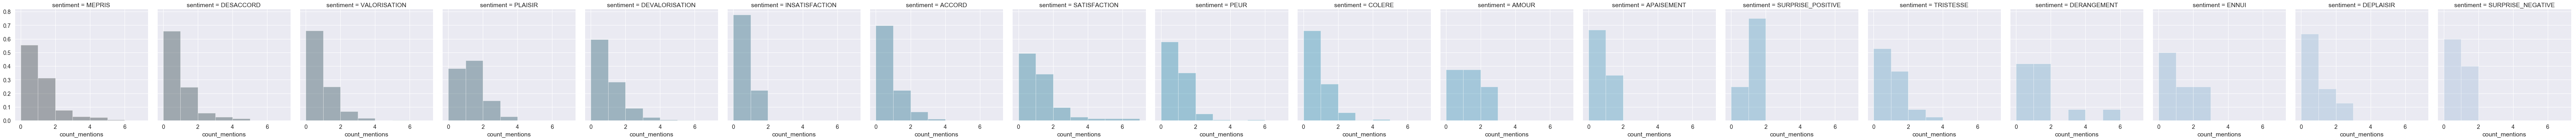

In [7]:
show_dist(df_eda_train, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%   75%   max
sentiment                                                               
ACCORD             153.0   0.895425  1.241621  0.0  0.0  0.0  1.00  6.0 
AMOUR              8.0     0.000000  0.000000  0.0  0.0  0.0  0.00  0.0 
APAISEMENT         9.0     0.888889  1.452966  0.0  0.0  0.0  2.00  4.0 
COLERE             209.0   0.488038  1.005323  0.0  0.0  0.0  1.00  6.0 
DEPLAISIR          47.0    0.489362  0.856493  0.0  0.0  0.0  1.00  3.0 
DERANGEMENT        12.0    1.083333  1.311372  0.0  0.0  1.0  1.25  4.0 
DESACCORD          216.0   0.773148  1.212118  0.0  0.0  0.0  1.00  6.0 
DEVALORISATION     396.0   0.780303  1.232355  0.0  0.0  0.0  1.00  8.0 
ENNUI              4.0     0.500000  0.577350  0.0  0.0  0.5  1.00  1.0 
INSATISFACTION     9.0     0.555556  1.013794  0.0  0.0  0.0  1.00  3.0 
MEPRIS             173.0   0.294798  0.731220  0.0

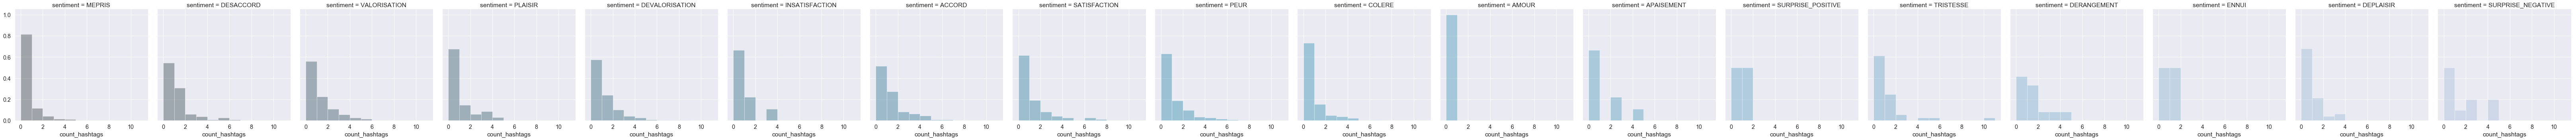

In [8]:
show_dist(df_eda_train, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%   75%   max
sentiment                                                               
ACCORD             153.0   0.411765  0.693289  0.0  0.0  0.0  1.00  3.0 
AMOUR              8.0     0.000000  0.000000  0.0  0.0  0.0  0.00  0.0 
APAISEMENT         9.0     1.555556  2.920236  0.0  0.0  0.0  1.00  8.0 
COLERE             209.0   0.755981  1.792821  0.0  0.0  0.0  1.00  11.0
DEPLAISIR          47.0    0.680851  2.934846  0.0  0.0  0.0  0.00  20.0
DERANGEMENT        12.0    0.500000  0.674200  0.0  0.0  0.0  1.00  2.0 
DESACCORD          216.0   0.555556  1.393228  0.0  0.0  0.0  1.00  10.0
DEVALORISATION     396.0   0.351010  1.216146  0.0  0.0  0.0  0.00  20.0
ENNUI              4.0     0.250000  0.500000  0.0  0.0  0.0  0.25  1.0 
INSATISFACTION     9.0     0.555556  0.726483  0.0  0.0  0.0  1.00  2.0 
MEPRIS             173.0   0.358382  1.2

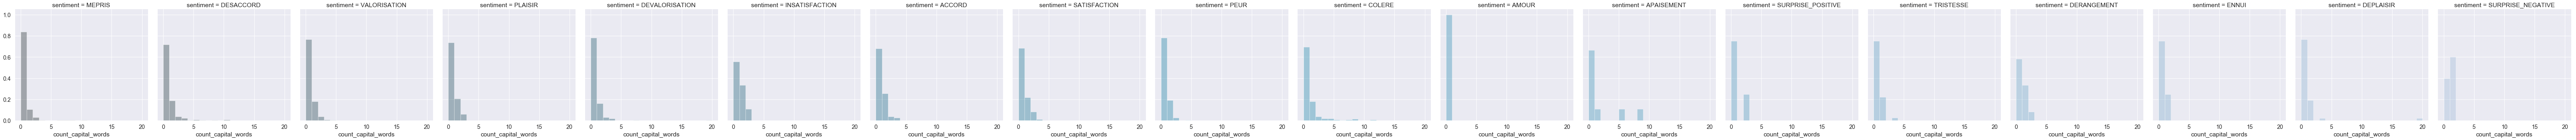

In [9]:
show_dist(df_eda_train, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
                    count      mean       std  min  25%  50%   75%   max
sentiment                                                               
ACCORD             153.0   0.111111  0.544779  0.0  0.0  0.0  0.00  6.0 
AMOUR              8.0     0.625000  1.407886  0.0  0.0  0.0  0.25  4.0 
APAISEMENT         9.0     0.111111  0.333333  0.0  0.0  0.0  0.00  1.0 
COLERE             209.0   0.631579  1.324023  0.0  0.0  0.0  1.00  10.0
DEPLAISIR          47.0    0.148936  0.465259  0.0  0.0  0.0  0.00  2.0 
DERANGEMENT        12.0    0.166667  0.389249  0.0  0.0  0.0  0.00  1.0 
DESACCORD          216.0   0.111111  0.381754  0.0  0.0  0.0  0.00  3.0 
DEVALORISATION     396.0   0.237374  0.742365  0.0  0.0  0.0  0.00  8.0 
ENNUI              4.0     0.250000  0.500000  0.0  0.0  0.0  0.25  1.0 
INSATISFACTION     9.0     0.000000  0.000000  0.0  0.0  0.0  0.00  0.0 
MEPRIS             173.0   0.49132

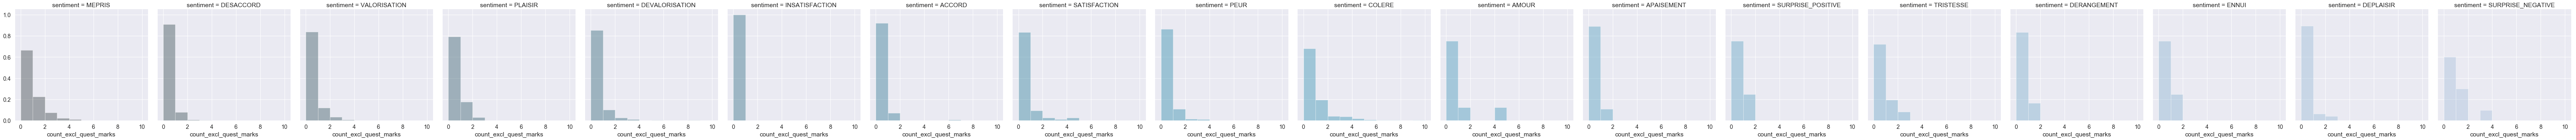

In [10]:
show_dist(df_eda_train, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
                    count  mean  std  min  25%  50%  75%  max
sentiment                                                    
ACCORD             153.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
AMOUR              8.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0
APAISEMENT         9.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0
COLERE             209.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
DEPLAISIR          47.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
DERANGEMENT        12.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
DESACCORD          216.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
DEVALORISATION     396.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
ENNUI              4.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0
INSATISFACTION     9.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0
MEPRIS             173.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
PEUR               273.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
PLAISIR            34.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
SATI

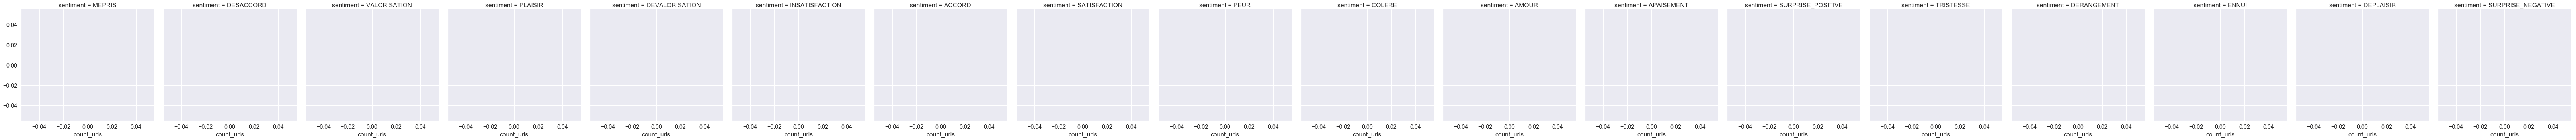

In [11]:
show_dist(df_eda_train, 'count_urls')

In [12]:
show_dist(df_eda, 'count_emojis')

NameError: name 'df_eda' is not defined

In [30]:
#get text features from test dataset
df_eda_test = textcount.fit_transform(df_tweet_fr_test.text)
df_eda_test['sentiment'] = df_tweet_fr_test.emotion
df_eda_test['origin_text'] = df_tweet_fr_test.text

Descriptive stats for count_words
---------------------------------
                   count       mean       std   min    25%   50%    75%   max
sentiment                                                                    
ACCORD             67.0   17.820896  4.468494  5.0   15.00  18.0  21.00  27.0
AMOUR              4.0    15.500000  7.234178  7.0   11.50  15.5  19.50  24.0
APAISEMENT         5.0    15.000000  3.741657  12.0  12.00  14.0  16.00  21.0
COLERE             87.0   18.954023  4.843860  4.0   17.00  20.0  22.50  28.0
DEPLAISIR          21.0   19.809524  5.240411  6.0   19.00  20.0  22.00  30.0
DERANGEMENT        6.0    16.333333  9.500877  4.0   9.75   16.5  22.50  29.0
DESACCORD          92.0   17.293478  3.541087  8.0   15.00  18.0  20.00  24.0
DEVALORISATION     170.0  18.358824  4.072648  8.0   16.00  19.0  21.00  28.0
ENNUI              2.0    21.000000  1.414214  20.0  20.50  21.0  21.50  22.0
INSATISFACTION     5.0    15.800000  5.630275  6.0   17.00  17.0  19.00  2

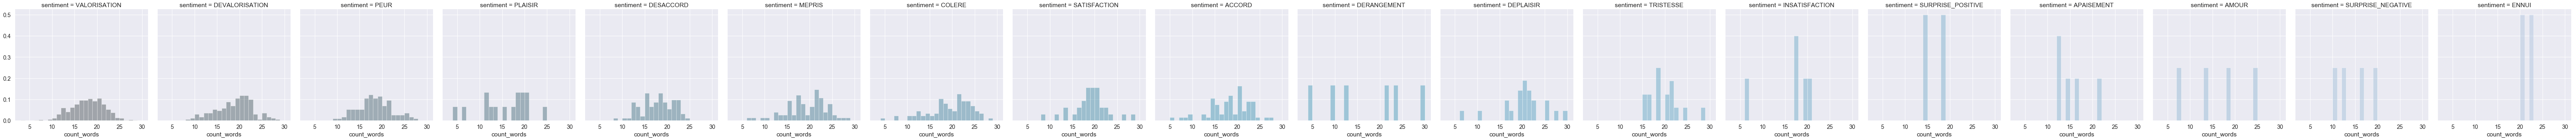

In [31]:
show_dist(df_eda_test, 'count_words')

In [52]:
class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    #def remove_hashtags(self, input_text):
        #return re.sub(r'#\w+', '', input_text)    
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_demojize(self, input_text):
        #demojize all emojis 
        return emoji.demojize(input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        #return re.sub(r':([a-z&]+)_([a-z&]+):', r'\1\2', input_text)
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def replace_acronyms(self, input_text):
        acronyms_dic = {"OMG":"oh mon dieu","omg":"oh mon dieu"}
        acronyms_pattern = re.compile(r'\b(' + '|'.join(acronyms_dic.keys()) + r')\b')
        return acronyms_pattern.sub(lambda x: acronyms_dic[x.group()], input_text)
        
    def stopwords_spell(self, input_text):
        stopwords_list = stopwords.words('French')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["ne", "pas","n'"]
        blacklist = ["rt",'http','les','co','via']
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and (word not in blacklist) and len(word) > 1] 
        #correct words
        #spell = SpellChecker()
        correct_words = [word for word in clean_words]
        return " ".join(correct_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_demojize).apply(self.emoji_oneword).apply(self.replace_acronyms).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.stopwords_spell)
        return clean_X

In [53]:
#clean train dataset
cleantext = CleanText()
sr_clean = cleantext.fit_transform(df_tweet_fr_train.text)
sr_clean.sample(5)

119     bordeaux trop argent garonne biodiversité fleuve menacée pollution métaux uljmljygh
2899    ministre ecologie ségolène royal persisté signé vendredi idé jrnksvtzru xuzilnzs tw
2325    tsss tsss tsss cette manie écologique aimer éoliennes chez autres                  
1480    gco écologistes strasbourgeois stupéfaits sqlsoldyu mulhouse eelv                  
570     faut dire fruges entre vaches éoliennes tocards pas grd chse fréquenter            
Name: text, dtype: object

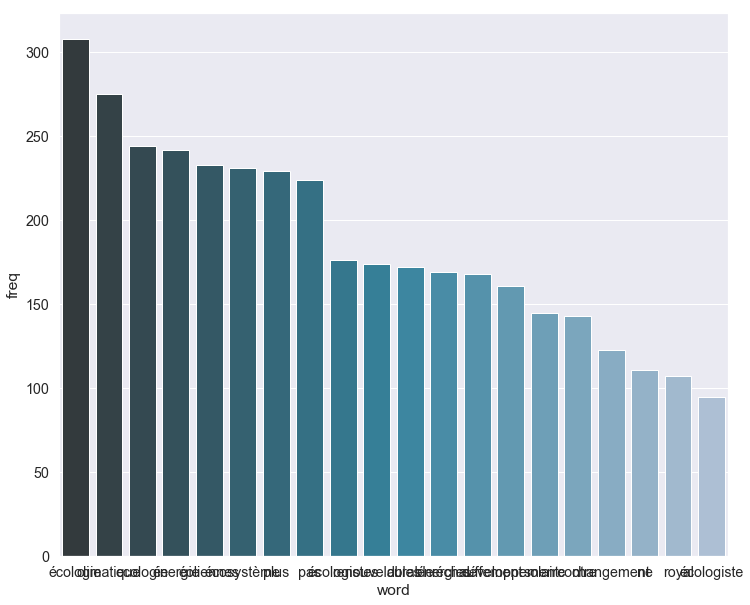

In [54]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

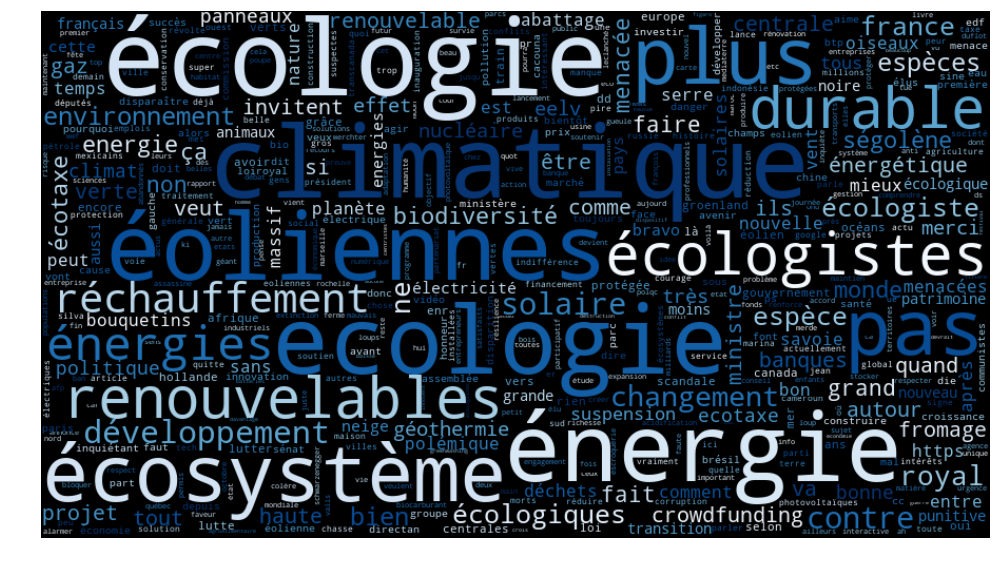

In [55]:
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(word_counter)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [56]:
df_model_fr_train = df_eda_train
df_model_fr_train['clean_text'] = sr_clean
df_model_fr_train = df_model_fr_train.drop_duplicates('clean_text')

In [57]:
df_model_fr_train.shape

(3147, 10)

In [58]:
df_model_fr_train.info

<bound method DataFrame.info of       count_words  count_mentions  count_hashtags  count_capital_words  \
0     24           3               0               0                     
1     21           0               0               0                     
2     20           0               0               0                     
3     20           1               0               0                     
4     19           1               0               0                     
5     26           0               2               0                     
6     16           0               0               0                     
7     12           2               0               1                     
8     14           0               1               0                     
9     25           0               0               0                     
10    15           0               0               0                     
11    20           0               0               1                     
12    

In [59]:
df_model_fr_train['clean_text'].replace('', np.nan, inplace=True)

In [60]:
df_model_fr_train = df_model_fr_train.dropna(axis=0, subset=['clean_text'])
df_model_fr_train.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,origin_text,clean_text
0,24,3,0,0,1,0,0,MEPRIS,@PhanEd @AznAlainT @_Baekholic alors j\'ai une blague mais dure a comprendre On est ecologiques a nous 3 on se rebelle groupe Anti-Train !,alors blague dure comprendre ecologiques rebelle groupe anti train
1,21,0,0,0,0,0,0,DESACCORD,"Madame Ségolène Royale ministre de l\'écologie et du développement durable Non à la destruction des \""nuisibles\"" http//t.co/jUYWddlIMe",madame ségolène royale ministre écologie développement durable non destruction nuisibles juywddlime
2,20,0,0,0,0,0,0,VALORISATION,"Le nouveau Monsieur \"" développement durable \"" Jacques Tapin l’ex-élu municipal niortais vient d’être porté ... http//t.co/hrDGKOkyJd",nouveau monsieur développement durable jacques tapin l’ex élu municipal niortais vient d’être porté hrdgkokyjd
3,20,1,0,0,0,0,0,DESACCORD,@F_Choquette pourquoi une pétition contre le changement climatique si vous etes meme pas capable de traiter un simple dossier citoyen,pourquoi pétition contre changement climatique si etes meme pas capable traiter simple dossier citoyen
4,19,1,0,0,0,0,0,PLAISIR,Content de participer au groupe de travail @LaFabriqueEcolo sur mondialisation et développement durable beaucoup d\'échanges et d\'énergie,content participer groupe travail mondialisation développement durable beaucoup échanges énergie


In [61]:
df_model_fr_train.to_pickle('../data/pickle_emotion/df_model_fr_train.p') # save dframe to pickle

In [62]:
#clean test dataset
sr_clean_test = cleantext.fit_transform(df_tweet_fr_test.text)
sr_clean_test.sample(5)

769     biodiversité méduses attaquent plages sud                                               
1104    lrt impossible soutenir là non violence partout nulle part racisme écologie incompatible
1289    manque innovation menace croissance monde                                               
327     gens signent pétition éviter prison «sauveuse canards» jeunes écologistes vieux «canne» 
495     ecologie concordia maire bastia alerte royal                                            
Name: text, dtype: object

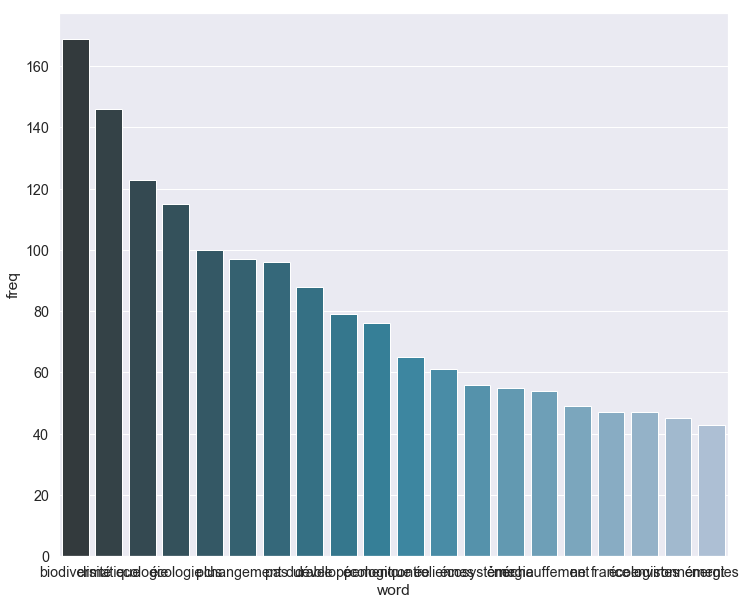

In [63]:
bow = cv.fit_transform(sr_clean_test)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter_test = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter_test.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

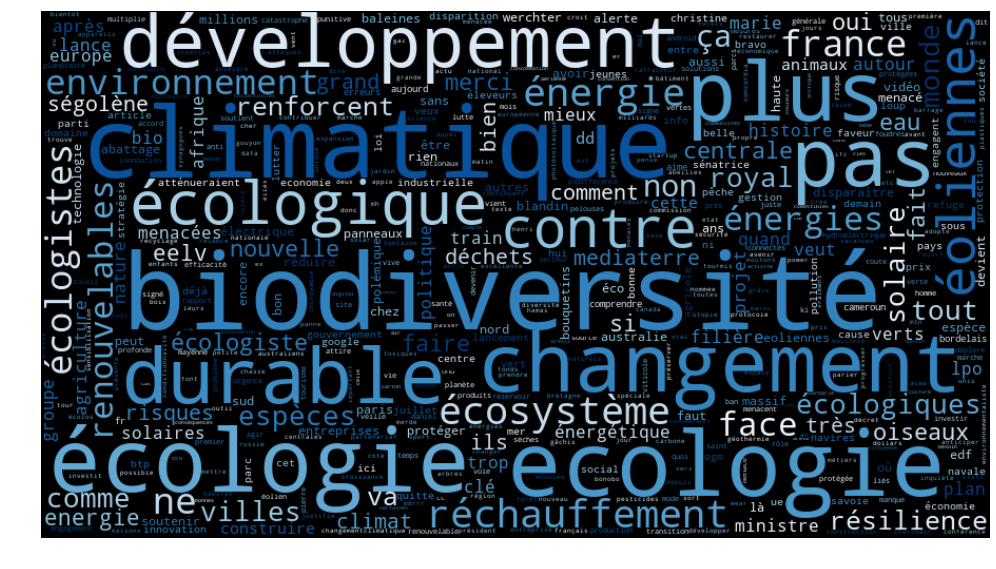

In [64]:
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(word_counter_test)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [65]:
df_model_fr_test = df_eda_test
df_model_fr_test['clean_text'] = sr_clean_test
df_model_fr_test = df_model_fr_test.drop_duplicates('clean_text')

In [66]:
df_model_fr_test.shape

(1284, 10)

In [67]:
df_model_fr_test['clean_text'].replace('', np.nan, inplace=True)

In [68]:
df_model_fr_test = df_model_fr_test.dropna(axis=0, subset=['clean_text'])
df_model_fr_test.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,origin_text,clean_text
0,11,0,0,0,0,1,0,VALORISATION,La technologie clé contre le changement climatique http://t.co/6jwCQsD8Vk,technologie clé contre changement climatique
1,16,2,0,0,0,0,0,DEVALORISATION,@JMoncomble Probablement une histoire de développement durable/recyclage universitaire toussa. Il est mauvaise ambiance le @MikaelAgopiantz,probablement histoire développement durable recyclage universitaire toussa mauvaise ambiance
2,25,0,0,0,3,1,0,VALORISATION,C\'est moi où l\'énergie naturelle est plus forte que d\'habitude...??! :o. Il y a des renversements de situations... http://t.co/0CQyWJvjh3,où énergie naturelle plus forte habitude renversements situations
3,20,0,2,0,0,1,0,VALORISATION,Nous cherchons à changer l’économie mondiale en nous basant sur le développement durable https://t.co/vjJxQ6ca2S #crowdfunding #économie,cherchons changer l’économie mondiale basant développement durable crowdfunding économie
4,22,1,0,1,0,0,0,VALORISATION,@RemiMathis Les achats par l\'Internet sont écologiques: pas d\'embouteillages ni essence ni parking ni RERB puant. On choisit au calme.,achats internet écologiques pas embouteillages ni essence ni parking ni rerb puant choisit calme


In [70]:
df_model_fr_test.to_pickle('../data/pickle_emotion/df_model_fr_test.p') # save dframe to pickle

In [71]:
positive_tweets = pd.Series(["j'aime l'internet des objets"])

df_counts_pos = textcount.transform(positive_tweets)
df_clean_pos = cleantext.transform(positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos
df_model_pos.to_pickle('../data/df_model_pos_fr.p')

In [72]:
negative_tweets = pd.Series(["je déteste l'internet des objets"
                      ,"je n'aime pas l'internet des objets"])

df_counts_neg = textcount.transform(negative_tweets)
df_clean_neg = cleantext.transform(negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg
df_model_neg.to_pickle('../data/df_model_neg_fr.p')